In [97]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GRU, Dense, Concatenate, TimeDistributed, RepeatVector
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import EarlyStopping

# 데이터 불러오기
df = pd.read_csv('../Data/using/dt_2.6/ByAstar_dt_2.6_1016.csv')

# 데이터프레임의 행을 셔플
df = df.sample(frac=1).reset_index(drop=True)

df = df.drop('Case', axis=1)

# 'Omega' 열이 있는지 확인하고, 있으면 1, 없으면 2로 설정
option_value = 1 if 'Omega' in df.columns else 2

df.head(n=10)

,gate length,Theta,Phi,dt,combination,total time,computing time
0,28,2.735711,4.039492,2.6,"[3, 3, 2, 2, 4, 4, 1, 1, 3, 3, 2, 2, 4, 4, 1, ...",72.8,310.778138
1,27,2.351392,3.144720,2.6,"[3, 3, 2, 2, 4, 4, 1, 1, 3, 3, 2, 2, 4, 4, 1, ...",70.2,154.942224
2,9,0.651605,2.406267,2.6,"[3, 3, 2, 2, 4, 1, 3, 3, 2]",23.4,34.716638
3,26,1.866202,2.151823,2.6,"[3, 3, 2, 2, 4, 4, 1, 1, 3, 3, 2, 2, 4, 4, 1, ...",67.6,32246.709511
4,13,1.275023,5.073046,2.6,"[3, 2, 2, 4, 4, 1, 1, 1, 3, 3, 2, 4, 4]",33.8,746.064931
5,10,0.764759,4.357054,2.6,"[2, 2, 4, 4, 1, 1, 3, 3, 4, 4]",26.0,18.441947
6,10,1.090449,4.055338,2.6,"[2, 2, 4, 4, 1, 1, 3, 3, 2, 2]",26.0,4.546557
7,6,0.631097,1.358842,2.6,"[2, 4, 4, 1, 1, 3]",15.6,17.810960
8,26,2.105337,4.268520,2.6,"[2, 2, 4, 4, 1, 1, 3, 3, 2, 2, 4, 4, 1, 1, 3, ...",67.6,2225.006986
9,19,1.532824,1.943521,2.6,"[1, 1, 3, 3, 2, 2, 4, 4, 1, 3, 2, 2, 4, 2, 4, ...",49.4,511.429900


In [98]:

# df = df.dropna(subset=['combination'])


In [99]:
import pennylane as qml

# Use the mixed state simulator to save some steps in plotting later
# default.qubit < default.mixed
dev = qml.device('default.mixed', wires=1)
@qml.qnode(dev)


def making_rho_1(theta, phi, omega):
    qml.Rot(phi, theta, omega, wires=0)
    return qml.density_matrix(wires=0)

In [100]:
from math import *

def hermitian_matrix_to_vector(matrix):
    
    # 행렬의 크기를 가져옴
    n = matrix.shape[0]

    # 에르미트 행렬인지 확인
    assert np.allclose(matrix, matrix.conj().T)

    # 상삼각 행렬의 원소를 가져와 벡터로 변환
    # vector = np.zeros((n * (n + 1)) // 2, dtype=complex)
    vector = np.zeros(n**2, dtype=complex)
    
    idx = 0
    # for i in range(n):
    #     for j in range(i + 1):
    #         vector[idx] = matrix[i, j]
    #         idx += 1
    for i in range(n):
        for j in range(n):
            vector[idx] = matrix[i, j]
            idx += 1

    return vector

# x-rotation operater
def Rx(theta):
    return np.matrix([  [cos(theta/2),    -1j*sin(theta/2)],
                        [-1j*sin(theta/2),    cos(theta/2)]])

# z-rotation operater
def Rz(phi): 
    return np.matrix([  [cos(phi/2)-1j*sin(phi/2),  0],
                        [0,  cos(phi/2)+1j*sin(phi/2)]])
    
# Initial state
init_wave = np.array([[1], [0]])
irho_init = np.kron(init_wave, init_wave.conj().T)


def making_rho_2(theta, phi):

    # Target state
    # Theta must move first and then phi move.
    target_U = Rz(theta) @ Rx(phi) 
    irho_target = target_U @ irho_init @ target_U.conj().T
    
    return irho_target

In [101]:
option_value

2

In [102]:
# Rho 열 추가하고 각 행에 대해 making_rho 함수 호출하여 값 할당
if option_value == 1:
    df['Rho'] = df.apply(lambda row: hermitian_matrix_to_vector(making_rho_1(row['Theta'], row['Phi'], row['Omega'])), axis=1)
else:
    df['Rho'] = df.apply(lambda row: hermitian_matrix_to_vector(making_rho_2(row['Theta'], row['Phi'])), axis=1)

In [103]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29528 entries, 0 to 29527
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   gate length     29528 non-null  int64  
 1   Theta           29528 non-null  float64
 2   Phi             29528 non-null  float64
 3   dt              29528 non-null  float64
 4   combination     29528 non-null  object 
 5   total time      29528 non-null  float64
 6   computing time  29528 non-null  float64
 7   Rho             29528 non-null  object 
dtypes: float64(5), int64(1), object(2)
memory usage: 1.8+ MB


In [104]:
df['Rho'][10]

array([0.72444908-2.75551629e-17j, 0.44606234-2.55146872e-02j,
       0.44606234+2.55146872e-02j, 0.27555092-7.89919567e-18j])

In [105]:
np.shape(df['Rho'][100])

(4,)

In [106]:
import tensorflow as tf

# 데이터셋 분리: train_set 8 : test_set 2
train_df, test_df = train_test_split(df, shuffle=True, test_size=0.2)
# train_set을 다시 8:2로 나눠서 train_set과 validation_set을 만듦
train_df, val_df = train_test_split(train_df, shuffle=True, test_size=0.2)
# random_state=42

# 모든 시퀀스의 길이 중에서 최대 길이를 구하기
all_sequences = [eval(str(seq)) for seq in df['combination'].values]
max_seq_length = max([len(seq) for seq in all_sequences])

# 각 데이터셋에서 theta, phi, sequence 추출하고 reshape 적용
theta_train = train_df['Theta'].values.reshape(-1, 1)
phi_train = train_df['Phi'].values.reshape(-1, 1)
# rho_train = train_df['Rho'].values.reshape(-1, 1)
rho_train_list = train_df['Rho'].apply(lambda x: np.asarray(x).flatten()).tolist()
rho_train = tf.constant(np.stack(rho_train_list))
sequence_train = pad_sequences(train_df['combination'].apply(eval).tolist(), maxlen=max_seq_length, padding='pre')

theta_val = val_df['Theta'].values.reshape(-1, 1)
phi_val = val_df['Phi'].values.reshape(-1, 1)
# rho_val = val_df['Rho'].values.reshape(-1, 1)
rho_val_list = val_df['Rho'].apply(lambda x: np.asarray(x).flatten()).tolist()
rho_val = tf.constant(np.stack(rho_val_list))
sequence_val = pad_sequences(val_df['combination'].apply(eval).tolist(), maxlen=max_seq_length, padding='pre')

theta_test = test_df['Theta'].values.reshape(-1, 1)
phi_test = test_df['Phi'].values.reshape(-1, 1)
# rho_test = test_df['Rho'].values.reshape(-1, 1)
rho_test_list = test_df['Rho'].apply(lambda x: np.asarray(x).flatten()).tolist()
rho_test = tf.constant(np.stack(rho_test_list))
sequence_test = pad_sequences(test_df['combination'].apply(eval).tolist(), maxlen=max_seq_length, padding='pre')


In [107]:
print("rho_train shape:", rho_train.shape)
print("rho_train dtype:", rho_train.dtype)
print("rho_val shape:", rho_val.shape)
print("rho_val dtype:", rho_val.dtype)
print(rho_train[0], rho_train[1])

rho_train shape: (18897, 4)
rho_train dtype: <dtype: 'complex128'>
rho_val shape: (4725, 4)
rho_val dtype: <dtype: 'complex128'>
tf.Tensor(
[0.95267547-2.66899698e-18j 0.20746497+4.52017778e-02j
 0.20746497-4.52017778e-02j 0.04732453+1.06346971e-18j], shape=(4,), dtype=complex128) tf.Tensor(
[0.84708765+2.60625310e-17j 0.34637938+9.77317354e-02j
 0.34637938-9.77317354e-02j 0.15291235+3.74095948e-18j], shape=(4,), dtype=complex128)


In [108]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# 모델 정의

ds_rho_input = Input(shape=(4,), name='density_matrix_input')

# 시퀀스를 예측하기 위한 GRU 레이어
repeated_vector = RepeatVector(max_seq_length)(ds_rho_input)  # max_sequence_length는 시퀀스의 최대 길이

rnn_layer = GRU(256, return_sequences=True, name='rnn_layer')(repeated_vector)

output = TimeDistributed(Dense(5, activation='softmax'), name='output_layer')(rnn_layer)

model = Model(inputs=[ds_rho_input], outputs=output)

# 컴파일 및 훈련
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

history = model.fit([rho_train], np.expand_dims(sequence_train, -1), 
                    validation_data=([rho_val], np.expand_dims(sequence_val, -1)), 
                    epochs=500, batch_size=128, callbacks=[early_stopping])

# 검증
loss, accuracy = model.evaluate([rho_test], np.expand_dims(sequence_test, -1))
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")


TypeError: Exception encountered when calling layer "rnn_layer" (type GRU).

Input 'b' of 'MatMul' Op has type float32 that does not match type complex128 of argument 'a'.

Call arguments received by layer "rnn_layer" (type GRU):
  • inputs=tf.Tensor(shape=(None, 35, 4), dtype=complex128)
  • mask=None
  • training=None
  • initial_state=None

In [ ]:
from tensorflow.keras.utils import plot_model

# 모델을 이미지 파일로 저장
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


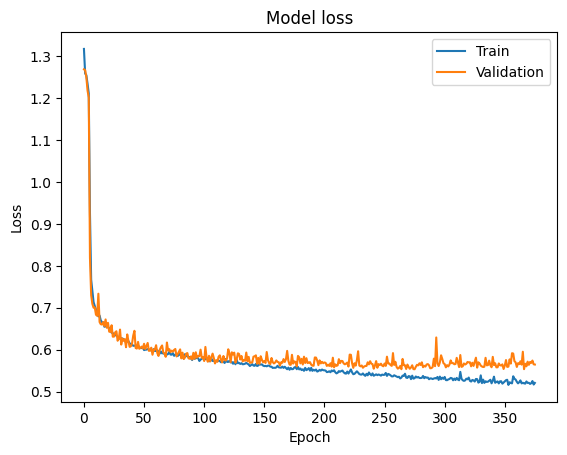

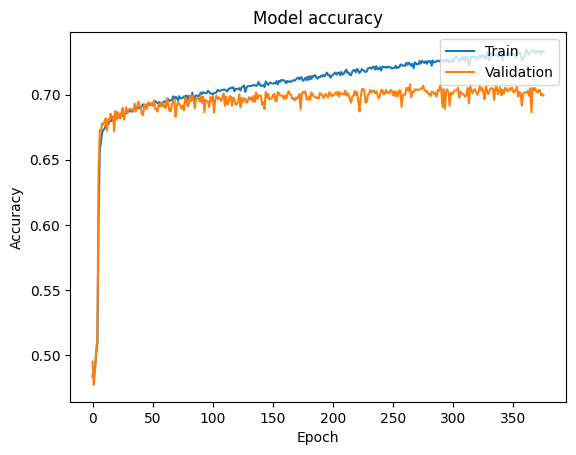

185/185 [==============================] - 2s 11ms/step - loss: 0.5576 - accuracy: 0.6968
Test Accuracy: 69.68
Test Loss: 55.76


In [ ]:
def plot_history(history):
         # Plot training & validation loss values
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        # plt.axis([45, 70, 0, 0.01])
        plt.legend(['Train', 'Validation'], loc='upper right')
        plt.show()

        # Plot training & validation accuracy values
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('Model accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        # plt.axis([45, 60, 0.999, 1.0])
        plt.legend(['Train', 'Validation'], loc='upper right')
        plt.show()

def evaluate(model, rho, sequence):
    loss, acc = model.evaluate({'density_matrix_input': rho}, np.expand_dims(sequence, -1))
    print("Test Accuracy: {:.2f}".format(acc*100))
    print("Test Loss: {:.2f}".format(loss*100))

# 결과 그래프 그리기
plot_history(history)

# 모델 성능 평가
evaluate(model, rho_test, sequence_test)

In [ ]:
# 결과를 저장할 디렉토리 생성
models_dir = 'saved_models'
if not os.path.exists(models_dir):
    os.makedirs(models_dir)
    
# 모델 저장
model.save(os.path.join(models_dir, "NVspin_GRU_model_Rho_ver2.h5"))

# # 모델 불러오기
# from tensorflow.keras.models import load_model
# loaded_model = load_model("SimpleRNN_model.h5")

c:\Python310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# 테스트 데이터셋에서 10개의 샘플을 무작위로 선택
indices = np.random.choice(len(rho_test), 10)

theta_samples = np.array(theta_test)[indices]
phi_samples = np.array(phi_test)[indices]
rho_samples = np.array(rho_test)[indices]
sequence_samples = np.array(sequence_test)[indices]

# 모델을 사용하여 예측 수행
predicted_sequences = model.predict([rho_samples])

# 가장 확률이 높은 클래스의 인덱스를 선택
predicted_sequences = np.argmax(predicted_sequences, axis=-1)

# 결과를 DataFrame으로 변환
df_results = pd.DataFrame({
    'Theta': theta_samples.ravel(),
    'Phi': phi_samples.ravel(),
    'Actual Sequence': [list(seq) for seq in sequence_samples],
    'Predicted Sequence': [list(seq) for seq in predicted_sequences]
})

# 결과를 저장할 디렉토리 생성
results_dir = 'sample_GRU'
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

# 결과를 CSV 파일로 저장
df_results.to_csv(os.path.join(results_dir, 'GRU_cuda_results_Rho_2.csv'), index=False)

print("Results saved to GRU_cuda_results_Rho_2.csv")


1/1 [==============================] - 0s 394ms/step
Results saved to GRU_cuda_results_Rho.csv


In [ ]:
# 테스트 데이터셋에서 10개의 샘플을 무작위로 선택
indices = np.random.choice(len(rho_test), 10)

theta_samples = np.array(theta_test)[indices]
phi_samples = np.array(phi_test)[indices]
rho_samples = np.array(rho_test)[indices]
sequence_samples = np.array(sequence_test)[indices]

# 모델을 사용하여 예측 수행
predicted_sequences = model.predict([rho_samples])

# 가장 확률이 높은 클래스의 인덱스를 선택
predicted_sequences = np.argmax(predicted_sequences, axis=-1)

# 결과 출력
for i in range(10):
    print(f"Sample {i + 1}:")
    print("Theta    :", theta_samples[i])
    print("Phi      :", phi_samples[i])
    print("Actual   :", sequence_samples[i])
    print("Predicted:", predicted_sequences[i])
    print("----------")


1/1 [==============================] - 0s 29ms/step
Sample 1:
Theta    : [2.64389947]
Phi      : [4.38843935]
Actual   : [0 0 0 0 0 0 0 0 2 2 4 4 1 1 3 3 2 2 4 4 1 1 3 3 2 2 4 4 1 1 3 3 2 2 4]
Predicted: [0 0 0 0 0 0 0 3 3 2 2 4 4 1 1 3 3 2 2 4 4 1 1 3 3 2 2 4 4 1 3 3 2 2 4]
----------
Sample 2:
Theta    : [3.02185404]
Phi      : [3.33612335]
Actual   : [0 0 3 2 2 4 4 1 1 3 3 2 2 4 4 1 1 3 3 2 2 4 4 1 1 3 3 2 2 4 4 1 1 1 1]
Predicted: [0 0 0 0 2 4 4 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
----------
Sample 3:
Theta    : [2.40048096]
Phi      : [2.29121505]
Actual   : [0 0 0 0 0 0 0 0 0 3 3 2 2 4 4 1 1 3 3 2 2 4 4 1 1 3 3 2 2 4 4 1 1 3 3]
Predicted: [0 0 0 0 0 0 0 0 0 0 0 2 2 4 4 1 1 3 3 2 2 4 4 1 1 3 3 2 2 4 4 1 1 3 3]
----------
Sample 4:
Theta    : [2.67435862]
Phi      : [5.25195599]
Actual   : [0 0 4 4 1 1 3 3 2 2 4 4 1 1 3 3 2 2 4 4 1 1 3 3 2 2 4 4 1 1 1 1 3 2 2]
Predicted: [0 0 0 0 0 0 0 0 2 4 4 1 1 1 3 3 2 4 4 0 1 1 3 2 2 4 4 1 1 3 3 2 2 4 4]
----------
Sample 5